## Model Evaluation for college scorecard - earnings prediction

This notebook will use several different supervised learning regression algorithms to model earnings after college using College Scorecard data. The models included for evaluation will be:

1. Linear Regression
1. Decision Tree
1. Random Forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
seed = 12345
#load the data

data = pd.read_pickle('clean_notna_data.pickle')
X = data['X']
y = data['y']
X_with_name = X.copy()
name = X['INSTNM']

X.drop('INSTNM', axis = 1, inplace = True)
data = X.copy()
data['Y'] = y

X.head()

,MAIN,NUMBRANCH,ADM_RATE,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,...,CCSIZSET_16.0,CCSIZSET_17.0,PFTFAC_ISNA,INEXPFTE_ISNA,AVGFACSAL_ISNA,GRAD_DEBT_MDN_ISNA,C150_4_ISNA,ADM_RATE_ISNA,TUITION_ISNA,TUITION_OUT_ISNT_IN
0,1,1.0,0.5575,0.0426,0.0019,0.0155,0.0000,0.0000,0.031,0.0756,...,0,0,0,0,0,0,0,0,0,1
1,1,1.0,0.9117,0.0000,0.0000,0.0000,0.0006,0.0540,0.000,0.0276,...,0,0,0,0,0,0,0,0,0,1
2,1,1.0,0.9050,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0574,...,0,0,0,0,0,0,0,0,0,1
3,1,1.0,0.6931,0.0000,0.0000,0.0000,0.0000,0.0393,0.000,0.1253,...,0,0,0,0,0,0,0,0,0,1
4,1,1.0,0.8462,0.0000,0.0000,0.0000,0.0041,0.1192,0.000,0.0164,...,1,0,0,0,0,0,0,0,0,1


In [18]:
class NaivePredictor:
    def __init__(self, use_coef=False):
        self.use_coef = use_coef

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.lookup = pd.concat([X[["INSTNM", "YEAR"]], y], axis=1)

    def _predict(self, instnm, year):
        query_str = f'INSTNM == "{instnm}" and YEAR == "{year - 2}"'
        try:
            last = self.lookup.query(query_str)["MD_EARN_AVG"].values[0]
        except IndexError:
            return np.nan
        coef = 1
        if self.use_coef:
            query_str_back = f'INSTNM == "{instnm}" and YEAR == "{year - 4}"'
            try:
                last_back = self.lookup.query(query_str_back)["MD_EARN_AVG"].values[0]
                coef = last / last_back
            except:
                return np.nan
        return coef * last

    def predict(self, X):
        result = X.apply(lambda x: self._predict(x["INSTNM"], x["YEAR"]), axis=1)
        return result

### Data preprocessing
We need to split the data into training and test sets. Also, we need to think about possibly centering/normalizing the data.

Normalizing may make sense at least for linear regression, so we can understand the features a little bit better

Also, we can think about using PCA (if only for visualization purposes)

In [3]:
# Split the data into training and test

train_test_index = {0:'',1:'',2:'',3:'',4:'',5:''}
for i in range(0,6):
    train_test_index[i] = {
        'train': X[X['YEAR'] <= i+2002].index,
        'test' : X[X['YEAR'] == i + 2003].index
    }
#X.drop('YEAR', axis = 1, inplace = True)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Naive Model

In [13]:
from sklearn.metrics import mean_squared_error as m_s_e
from sklearn.metrics import mean_absolute_error as m_a_e
from sklearn.metrics import r2_score

np_a = NaivePredictor()
np_a.fit(X_with_name, y)
y_hat_a = np_a.predict(X_with_name)
y_hat_a = y_hat_a[~np.isnan(y_hat_a)]
y_true = y[y_hat_a.index]
r2 = r2_score(y_true, y_hat_a)
mse = m_s_e(y_true, y_hat_a)
mae = m_a_e(y_true, y_hat_a)
print("R^2: ", r2)
print("MSE1: ", mse)
print("RMSE of validation set: ", np.sqrt(mse))
print("MAE of validation set: ", mae)
print("original shape:", y.shape)
print("final shape:", y_true.shape)

R^2:  0.9313703564291421
MSE1:  5555408.033887464
RMSE of validation set:  2356.991309675847
MAE of validation set:  1630.009093593812
original shape: (11201,)
final shape: (8017,)


In [19]:
np_b = NaivePredictor(use_coef=True)
np_b.fit(X_with_name, y)
y_hat_b = np_b.predict(X_with_name)
y_hat_b = y_hat_b[~np.isnan(y_hat_b)]
y_true = y[y_hat_b.index]
r2 = r2_score(y_true, y_hat_b)
mse = m_s_e(y_true, y_hat_b)
mae = m_a_e(y_true, y_hat_b)
print("R^2: ", r2)
print("MSE1: ", mse)
print("RMSE of validation set: ", np.sqrt(mse))
print("MAE of validation set: ", mae)
print("original shape:", y.shape)
print("final shape:", y_true.shape)

R^2:  0.8838256459832684
MSE1:  9586271.025482714
RMSE of validation set:  3096.1703805641437
MAE of validation set:  2273.533469374398
original shape: (11201,)
final shape: (4813,)


In [22]:
X_with_name[X_with_name['YEAR'] == 2003].shape

(1567, 201)

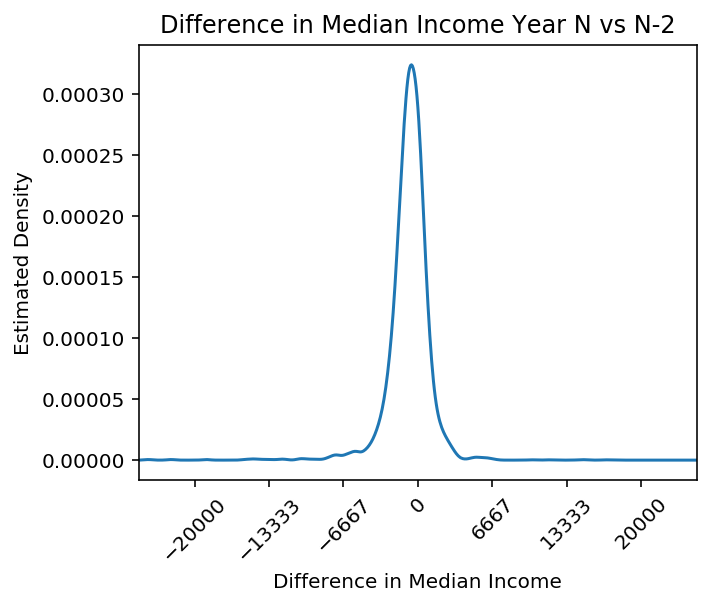

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize=(5, 4))
diffs = y_hat_a - y_true
diffs.plot.kde(ax=ax)
ax.set_xlim(-25000,25000)
plt.xticks([-20000,-13333,-6667,0,6667,13333,20000]);
ax.set_ylabel('Estimated Density')
ax.set_xlabel('Difference in Median Income')
ax.set_title('Difference in Median Income Year N vs N-2')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.savefig("figs/diffs.png",dpi=300,bbox_inches = 'tight')

In [12]:
diffs.shape

(8017,)

In [15]:
diffs[abs(diffs) < 5000].shape

(7753,)

In [75]:
X_with_name_test.shape

(9642, 201)

### Linear Regression
First try: no feature scaling

In [7]:
from sklearn.linear_model import LinearRegression

r2_array = {'train': list(), 'val': list()}
mse_array = {'train': list(), 'val': list()}
mae_array = {'train': list(), 'val': list()}

linreg_coeffs = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    r2_array['train'].append(lin_reg.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, lin_reg.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, lin_reg.predict(X_train)))
    
    r2_array['val'].append(lin_reg.score(X_test, y_test))
    mse_array['val'].append(m_s_e(y_test, lin_reg.predict(X_test)))
    mae_array['val'].append(m_a_e(y_test, lin_reg.predict(X_test)))
    
    linreg_coeffs += lin_reg.coef_
    
linreg_coeffs /= 6
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of validation set: ',np.mean(r2_array['val']))
print('MSE of validation set: ',np.mean(mse_array['val']))
print('RMSE of validation set: ', np.sqrt(np.mean(mse_array['val'])))
print('MAE of validation set: ',np.mean(mae_array['val']))
print()
print('Coefficients:')
sorted_inds = np.argsort((-np.abs(linreg_coeffs)))[:20]
for i in sorted_inds:
    print(X.columns[i], ': ', linreg_coeffs[i])

R^2 of training set:  0.8443275776215952
MSE of training set:  13233461.184335917
RMSE of training set:  3637.782454234436
MAE of training set:  2582.407404887728

R^2 of validation set:  0.8235120459549399
MSE of validation set:  14431083.81119437
RMSE of validation set:  3798.826636106782
MAE of validation set:  2807.925924057543

Coefficients:
PCIP14 :  126617.01324113214
PCIP54 :  121416.51400992817
PCIP29 :  117148.6009027461
PCIP10 :  107686.33649918296
PCIP46 :  107424.44710733881
PCIP47 :  106262.06654776866
PCIP15 :  105649.15205415011
PCIP48 :  103720.12985702284
PCIP51 :  102840.36480345721
PCIP52 :  102268.3882311622
PCIP40 :  101648.14149801088
PCIP11 :  100591.49340248905
PCIP27 :  100455.53642400615
PCIP41 :  99997.09718027299
PCIP31 :  99093.96477840662
PCIP24 :  98503.43104234674
PCIP49 :  98141.41346993916
PCIP22 :  97909.14670535004
PCIP43 :  97172.0996083839
PCIP13 :  96529.03657923


Second try: feature scaling

In [8]:
from sklearn.preprocessing import RobustScaler


r2_array = {'train': list(), 'val': list()}
mse_array = {'train': list(), 'val': list()}
mae_array = {'train': list(), 'val': list()}

linreg_coeffs = np.zeros_like(X.columns)
for i in range(1,6):
    scaler = RobustScaler()

    X_train = X.loc[train_test_index[i]['train']]
    X_train_scaled = scaler.fit_transform(X_train)
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    X_test_scaled = scaler.transform(X_test)
    y_test = y.iloc[train_test_index[i]['test']]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    
    r2_array['train'].append(lin_reg.score(X_train_scaled, y_train))
    mse_array['train'].append(m_s_e(y_train, lin_reg.predict(X_train_scaled)))
    mae_array['train'].append(m_a_e(y_train, lin_reg.predict(X_train_scaled)))
    
    r2_array['val'].append(lin_reg.score(X_test_scaled, y_test))
    mse_array['val'].append(m_s_e(y_test, lin_reg.predict(X_test_scaled)))
    mae_array['val'].append(m_a_e(y_test, lin_reg.predict(X_test_scaled)))
    linreg_coeffs += (lin_reg.coef_ / scaler.scale_)
    
linreg_coeffs /= 5
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of validation set: ',np.mean(r2_array['val']))
print('MSE of validation set: ',np.mean(mse_array['val']))
print('RMSE of validation set: ', np.sqrt(np.mean(mse_array['val'])))
print('MAE of validation set: ',np.mean(mae_array['val']))
print()
print('Coefficients:')
sorted_inds = np.argsort((-np.abs(linreg_coeffs)))[:20]
for i in sorted_inds:
    print(X.columns[i], ': ', linreg_coeffs[i])

R^2 of training set:  0.8432987120482511
MSE of training set:  13235313.349655945
RMSE of training set:  3638.0370187308354
MAE of training set:  2588.41035012447

R^2 of validation set:  0.8209231597997428
MSE of validation set:  14454277.607111042
RMSE of validation set:  3801.878168367714
MAE of validation set:  2846.6167947218332

Coefficients:
PCIP14 :  115177.68372245866
PCIP54 :  108616.07352057195
PCIP29 :  106037.95539438461
PCIP46 :  95382.88980459918
PCIP10 :  94559.35205267534
PCIP15 :  94266.18343508552
PCIP47 :  94240.64508257601
PCIP48 :  92714.48857764996
PCIP51 :  91292.92777904097
PCIP52 :  90635.13123661776
PCIP41 :  90062.78368798214
PCIP40 :  89980.38429889039
PCIP11 :  89014.87540629436
PCIP27 :  88385.34734017422
PCIP31 :  87582.69807734559
PCIP24 :  86805.24690380851
PCIP49 :  86652.75275704866
PCIP22 :  86427.4651687786
PCIP43 :  85294.67524454338
PCIP13 :  85103.1343263714


### Random forest


In [9]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 120
max_features = [0.3,0.4,0.5,0.66,0.75,0.9,0.99, 1]

# initialize accuracy dict which will have accuracy values for each run of the parameter tuning
accuracy_dict = dict()
for max_f in max_features:
    accuracy_dict[max_f] = {'r2':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}},
                            'mse':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}},
                            'mae':
                                {'train':
                                    {'list':list(),
                                     'mean': 0},
                                'test':
                                    {'list':list(),
                                     'mean': 0},
                                'oob':
                                    {'list':list(),
                                     'mean': 0}}}

for max_f in max_features:
    for i in range(0,6):
        X_train = X.loc[train_test_index[i]['train']]
        y_train = y.iloc[train_test_index[i]['train']]
        X_test = X.loc[train_test_index[i]['test']]
        y_test = y.iloc[train_test_index[i]['test']]
        rand_forest = RandomForestRegressor(n_estimators = n_estimators, max_features = max_f,
                                        criterion = 'mse', oob_score = True, random_state = seed)
        rand_forest.fit(X_train, y_train)

        accuracy_dict[max_f]['r2']['oob']['list'].append(rand_forest.oob_score_)
        accuracy_dict[max_f]['mse']['oob']['list'].append(m_s_e(y_train, rand_forest.oob_prediction_))
        accuracy_dict[max_f]['mae']['oob']['list'].append(m_a_e(y_train, rand_forest.oob_prediction_))
        
        accuracy_dict[max_f]['r2']['train']['list'].append(rand_forest.score(X_train, y_train))
        accuracy_dict[max_f]['mse']['train']['list'].append(m_s_e(y_train, rand_forest.predict(X_train)))
        accuracy_dict[max_f]['mae']['train']['list'].append(m_a_e(y_train, rand_forest.predict(X_train)))
        
        accuracy_dict[max_f]['r2']['test']['list'].append(rand_forest.score(X_test, y_test))
        accuracy_dict[max_f]['mse']['test']['list'].append(m_s_e(y_test, rand_forest.predict(X_test)))
        accuracy_dict[max_f]['mae']['test']['list'].append(m_a_e(y_test, rand_forest.predict(X_test)))
    
    
    accuracy_dict[max_f]['r2']['oob']['mean'] = np.mean(accuracy_dict[max_f]['r2']['oob']['list'])
    accuracy_dict[max_f]['mse']['oob']['mean'] = np.mean(accuracy_dict[max_f]['mse']['oob']['list'])
    accuracy_dict[max_f]['mae']['oob']['mean'] = np.mean(accuracy_dict[max_f]['mae']['oob']['list'])
    
    accuracy_dict[max_f]['r2']['train']['mean'] = np.mean(accuracy_dict[max_f]['r2']['train']['list'])
    accuracy_dict[max_f]['mse']['train']['mean'] = np.mean(accuracy_dict[max_f]['mse']['train']['list'])
    accuracy_dict[max_f]['mae']['train']['mean'] = np.mean(accuracy_dict[max_f]['mae']['train']['list'])
                            
    accuracy_dict[max_f]['r2']['test']['mean'] = np.mean(accuracy_dict[max_f]['r2']['test']['list'])
    accuracy_dict[max_f]['mse']['test']['mean'] = np.mean(accuracy_dict[max_f]['mse']['test']['list'])
    accuracy_dict[max_f]['mae']['test']['mean'] = np.mean(accuracy_dict[max_f]['mae']['test']['list'])
    print(max_f)
                            
#change other parameters as we see fit (probably max_depth, min_size_leaf, min_size_split)

0.3
0.4
0.5
0.66
0.75
0.9
0.99
1


In [10]:
column_pairs = list()
groups = ['oob', 'train', 'test']
metrics = ['r2', 'rmse', 'mae']
for group in groups:
    for metric in metrics:
        column_pairs.append((group, metric))

micolumns = pd.MultiIndex.from_tuples(column_pairs)

accuracy_means = pd.DataFrame(columns = micolumns)

In [11]:
for max_f in max_features:
    oob_r2 = accuracy_dict[max_f]['r2']['oob']['mean']
    oob_mse = accuracy_dict[max_f]['mse']['oob']['mean']
    oob_rmse = np.sqrt(oob_mse)
    oob_mae = accuracy_dict[max_f]['mae']['oob']['mean']
    
    train_r2 = accuracy_dict[max_f]['r2']['train']['mean']
    train_mse = accuracy_dict[max_f]['mse']['train']['mean']
    train_rmse = np.sqrt(train_mse)
    train_mae = accuracy_dict[max_f]['mae']['train']['mean']
    
    test_r2 = accuracy_dict[max_f]['r2']['test']['mean']
    test_mse = accuracy_dict[max_f]['mse']['test']['mean']
    test_rmse = np.sqrt(test_mse)
    test_mae = accuracy_dict[max_f]['mae']['test']['mean']
    
    accuracy_means.loc[max_f] = [oob_r2, oob_rmse, oob_mae,train_r2,train_rmse,train_mae,
                                 test_r2,test_rmse,test_mae]
accuracy_means.sort_index(inplace = True)
accuracy_means

oob                               train                           \
            r2         rmse          mae        r2         rmse         mae   
0.30  0.887219  3113.038612  2037.288593  0.978480  1357.791803  812.355671   
0.40  0.889264  3084.324011  2031.897217  0.978824  1346.778906  809.860985   
0.50  0.889220  3084.764597  2021.327489  0.978843  1346.061049  805.890470   
0.66  0.889124  3086.359317  2032.543766  0.978826  1346.740629  810.189220   
0.75  0.887884  3103.609501  2035.878129  0.978673  1351.626533  811.090704   
0.90  0.886629  3120.689715  2054.782310  0.978539  1355.789074  818.024142   
0.99  0.887343  3110.481332  2053.717540  0.978659  1351.851940  817.633023   
1.00  0.848217  3615.563821  2350.576515  0.973032  1521.833137  928.317892   

          test                            
            r2         rmse          mae  
0.30  0.911918  2684.956723  1952.165187  
0.40  0.911342  2693.458399  1946.700089  
0.50  0.909611  2719.674324  1957.889659  
0.66  0.908086  2740.934543  1966.498220  
0.75  0.907507  2749.680982  1978.825049  
0.90  0.904384  2795.560763  1992.132238  
0.99  0.902940  2816.152723  1999.915482  
1.00  0.904487  2799.713202  2013.315893

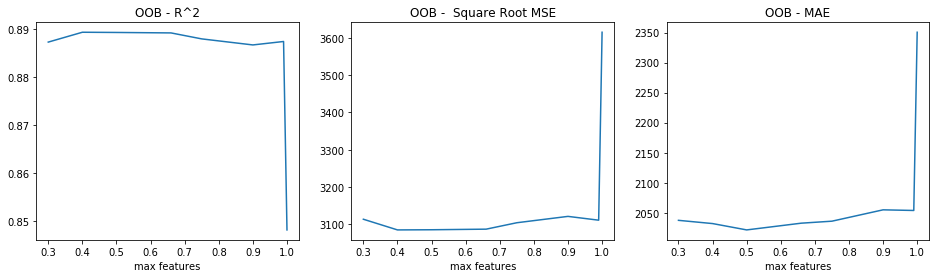

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(16,4))
ax1.plot(accuracy_means.index, accuracy_means['oob', 'r2'])
ax1.title.set_text('OOB - R^2')
ax1.set_xlabel('max features')
ax2.plot(accuracy_means.index, accuracy_means['oob', 'rmse'])
ax2.title.set_text('OOB -  Square Root MSE')
ax2.set_xlabel('max features')
ax3.plot(accuracy_means.index, accuracy_means['oob', 'mae'])
ax3.title.set_text('OOB - MAE')
ax3.set_xlabel('max features')
plt.show()

##### Using optimal max_features to find feature importance

In [13]:
best_max_f = 0.5

r2_array = {'train': list(), 'test': list()}
mse_array = {'train': list(), 'test': list()}
mae_array = {'train': list(), 'test': list()}
oob_array = []

feature_importances = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    rand_forest = RandomForestRegressor(criterion = 'mse',oob_score = True, max_features = best_max_f,
                                        random_state = seed, n_estimators = 100)
    rand_forest.fit(X_train, y_train)
    
    oob_array.append(rand_forest.oob_score_)
    
    r2_array['train'].append(rand_forest.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, rand_forest.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, rand_forest.predict(X_train)))
    
    r2_array['test'].append(rand_forest.score(X_test, y_test))
    mse_array['test'].append(m_s_e(y_test, rand_forest.predict(X_test)))
    mae_array['test'].append(m_a_e(y_test, rand_forest.predict(X_test)))
    
    feature_importances += rand_forest.feature_importances_
feature_importances /= 6

print('OOB score : ', np.mean(oob_array))
print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of Test set: ',np.mean(r2_array['test']))
print('MSE of Test set: ',np.mean(mse_array['test']))
print('RMSE of Test set: ', np.sqrt(np.mean(mse_array['test'])))
print('MAE of Test set: ',np.mean(mae_array['test']))
print()

OOB score :  0.8879345913590689
R^2 of training set:  0.9785216573139004
MSE of training set:  1839584.521695811
RMSE of training set:  1356.3128406440053
MAE of training set:  809.732678147108

R^2 of Test set:  0.9091744525514445
MSE of Test set:  7433713.74025074
RMSE of Test set:  2726.4837685654284
MAE of Test set:  1961.5910054593467



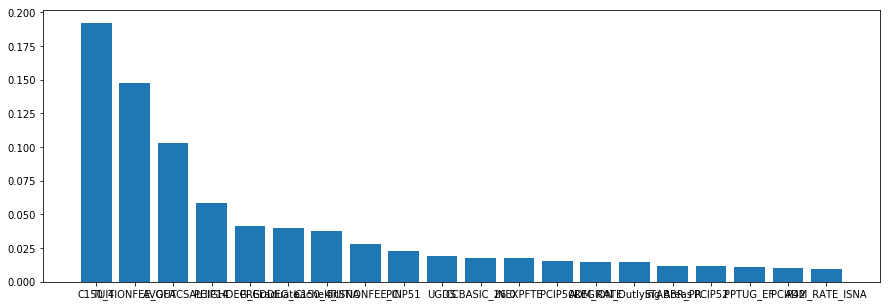

C150_4 :  0.19203746768431532
TUITIONFEE_OUT :  0.1478679382752011
AVGFACSAL :  0.10289588510049691
PCIP14 :  0.05829204024799839
HIGHDEG_Graduate :  0.041751233426431444
PREDDEG_bachelor :  0.040007713117999714
C150_4_ISNA :  0.03812255008563618
TUITIONFEE_IN :  0.02787874417831902
PCIP51 :  0.02259672440532939
UGDS :  0.018924985711001218
CCBASIC_26.0 :  0.0179581269248042
INEXPFTE :  0.01778850716964453
PCIP50 :  0.015426337354037159
ADM_RATE :  0.014945206226090413
REGION_Outlying Areas  :  0.014544520428483471
STABBR_PR :  0.01160677063478041
PCIP52 :  0.0115735002814613
PPTUG_EF :  0.010941050860082584
PCIP42 :  0.010554181193160423
ADM_RATE_ISNA :  0.009713786825057094


In [14]:
x = np.arange(20)
sorted_inds = np.argsort(-(feature_importances))[:20]
sorted_colnames = X.columns[sorted_inds]
fig = plt.figure(figsize = (15,5))
plt.bar(x,feature_importances[sorted_inds], width = 0.8)
plt.xticks(x,(sorted_colnames))
plt.show()
for i in range(0,20):
    print(sorted_colnames[i],': ', feature_importances[sorted_inds[i]])

Least accurate predictions

In [15]:
prediction = rand_forest.predict(X_test)
diff = y_test - prediction
absdiff = np.abs(prediction - y_test)
sorted_inds = np.argsort(-(absdiff))[:10]

for i in sorted_inds:
    name_index = train_test_index[5]['test'][i]
    print(name[name_index])
    print('predicted value:\t',prediction[i])
    print('real value:\t\t', y_test[name_index])
    print('difference:\t\t', diff[name_index])
    print()

Union College
predicted value:	 34019.12845947373
real value:		 51118.796099869454
difference:		 17099.667640395724

Union College
predicted value:	 36899.72309229433
real value:		 51118.796099869454
difference:		 14219.073007575127

Emmanuel College
predicted value:	 38223.11129987883
real value:		 26327.71662859008
difference:		 -11895.394671288752

Wentworth Institute of Technology
predicted value:	 43880.94999421583
real value:		 54601.84032310705
difference:		 10720.890328891219

Duke University
predicted value:	 68227.622596027
real value:		 78163.61006853786
difference:		 9935.987472510868

Grand Canyon University
predicted value:	 38233.28604038504
real value:		 29093.663511749346
difference:		 -9139.622528635697

MCPHS University
predicted value:	 86677.03104344365
real value:		 77548.95520561357
difference:		 -9128.075837830082

United Talmudical Seminary
predicted value:	 22263.36980339271
real value:		 13317.52203002611
difference:		 -8945.8477733666

Rust College
predicted

Most accurate predictions

In [16]:
prediction = rand_forest.predict(X_test)
diff = y_test - prediction
absdiff = np.abs(prediction - y_test)
sorted_inds = np.argsort(absdiff)[:10]

for i in sorted_inds:
    name_index = train_test_index[5]['test'][i]
    print(name[name_index])
    print(prediction[i])
    print(y_test[name_index])
    print(diff[name_index])
    print()

Holy Family University
41384.6700079958
41386.760770234985
2.090762239182368

West Hills College-Lemoore
24583.415728314227
24586.194516971278
2.7787886570513365

Keuka College
38933.9018649612
38928.141318537855
-5.760546423342021

St Bonaventure University
38013.147775133264
38006.159024151435
-6.988750981829071

Adelphi University
44554.21840237398
44562.47756201044
8.259159636458207

San Diego City College
23653.90413156503
23664.212222584854
10.308091019825952

Lake Michigan College
23470.438426064848
23459.327268276764
-11.111157788083801

Indiana State University
32565.29183499028
32576.707734986943
11.415899996663939

Snead State Community College
22958.945768771715
22947.11488250653
-11.830886265186564

Chowan University
25291.306851255904
25303.291857049608
11.985005793703749



## Gradient Tree Boosting

While Random Forest is an *averaging* ensemble method, gradient tree boosting is by contrast a *boosting* ensenble method by which base estimators are built sequentially and the goal is to reduce the bias of the combined estimator. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Model

#Set up arrays for evaluating results
r2_array = {'train': list(), 'test': list()}
mse_array = {'train': list(), 'test': list()}
mae_array = {'train': list(), 'test': list()}

# To start will use these hyperparameters
loss = 'ls' #default -- least squares
n_estimators = 500 #default is 100 but GB is very robust to overfitting so ok to use more
learning_rate = 0.1 #default
max_depth = 1 #default


feature_importances = np.zeros_like(X.columns)
for i in range(0,6):
    X_train = X.loc[train_test_index[i]['train']]
    y_train = y.iloc[train_test_index[i]['train']]
    X_test = X.loc[train_test_index[i]['test']]
    y_test = y.iloc[train_test_index[i]['test']]
    gbr = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
        max_depth=max_depth, random_state=0, loss=loss)
    gbr.fit(X_train, y_train)
    
    r2_array['train'].append(gbr.score(X_train, y_train))
    mse_array['train'].append(m_s_e(y_train, gbr.predict(X_train)))
    mae_array['train'].append(m_a_e(y_train, gbr.predict(X_train)))
    
    r2_array['test'].append(gbr.score(X_test, y_test))
    mse_array['test'].append(m_s_e(y_test, gbr.predict(X_test)))
    mae_array['test'].append(m_a_e(y_test, gbr.predict(X_test)))
    
    feature_importances += gbr.feature_importances_
feature_importances /= 6


print('R^2 of training set: ',np.mean(r2_array['train']))
print('MSE of training set: ',np.mean(mse_array['train']))
print('RMSE of training set: ', np.sqrt(np.mean(mse_array['train'])))
print('MAE of training set: ',np.mean(mae_array['train']))
print()
print('R^2 of Test set: ',np.mean(r2_array['test']))
print('MSE of Test set: ',np.mean(mse_array['test']))
print('RMSE of Test set: ', np.sqrt(np.mean(mse_array['test'])))
print('MAE of Test set: ',np.mean(mae_array['test']))
print()

R^2 of training set:  0.8298320996888718
MSE of training set:  14454970.038368069
RMSE of training set:  3801.969231644053
MAE of training set:  2724.8084779881415

R^2 of Test set:  0.7977496600680826
MSE of Test set:  16531370.477139687
RMSE of Test set:  4065.8788074830377
MAE of Test set:  2978.6400471722377



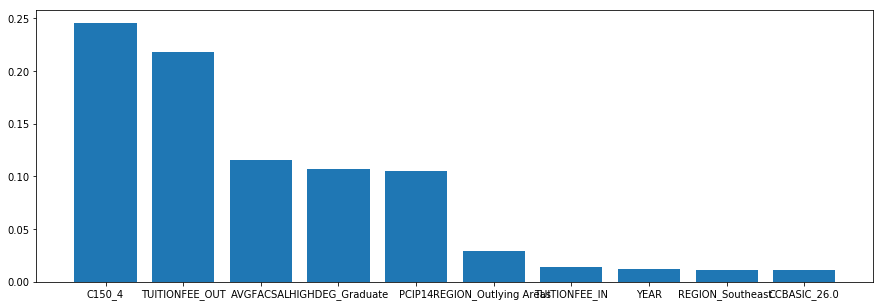

C150_4 :  0.24558705174943796
TUITIONFEE_OUT :  0.21784662493433685
AVGFACSAL :  0.11581489572590314
HIGHDEG_Graduate :  0.10672630883483443
PCIP14 :  0.1047707018357218
REGION_Outlying Areas  :  0.028951680818978698
TUITIONFEE_IN :  0.01413325107493007
YEAR :  0.011764657745818216
REGION_Southeast  :  0.011150598339435235
CCBASIC_26.0 :  0.011128689674465514


In [18]:
# Plot feature importance

x = np.arange(10)
sorted_inds = np.argsort(-(feature_importances))[:10]
sorted_colnames = X.columns[sorted_inds]
fig = plt.figure(figsize = (15,5))
plt.bar(x,feature_importances[sorted_inds], width = 0.8)
plt.xticks(x,(sorted_colnames))
plt.show()
for i in range(0,10):
    print(sorted_colnames[i],': ', feature_importances[sorted_inds[i]])

Text(0, 0.5, 'Deviance')

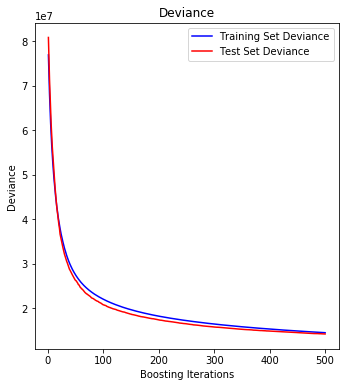

In [19]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(n_estimators) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')